In [1]:
import copy
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'RM_baseline')))

from model import DoraNet
from util import *
from dataset import DoraSet, DoraSetComb

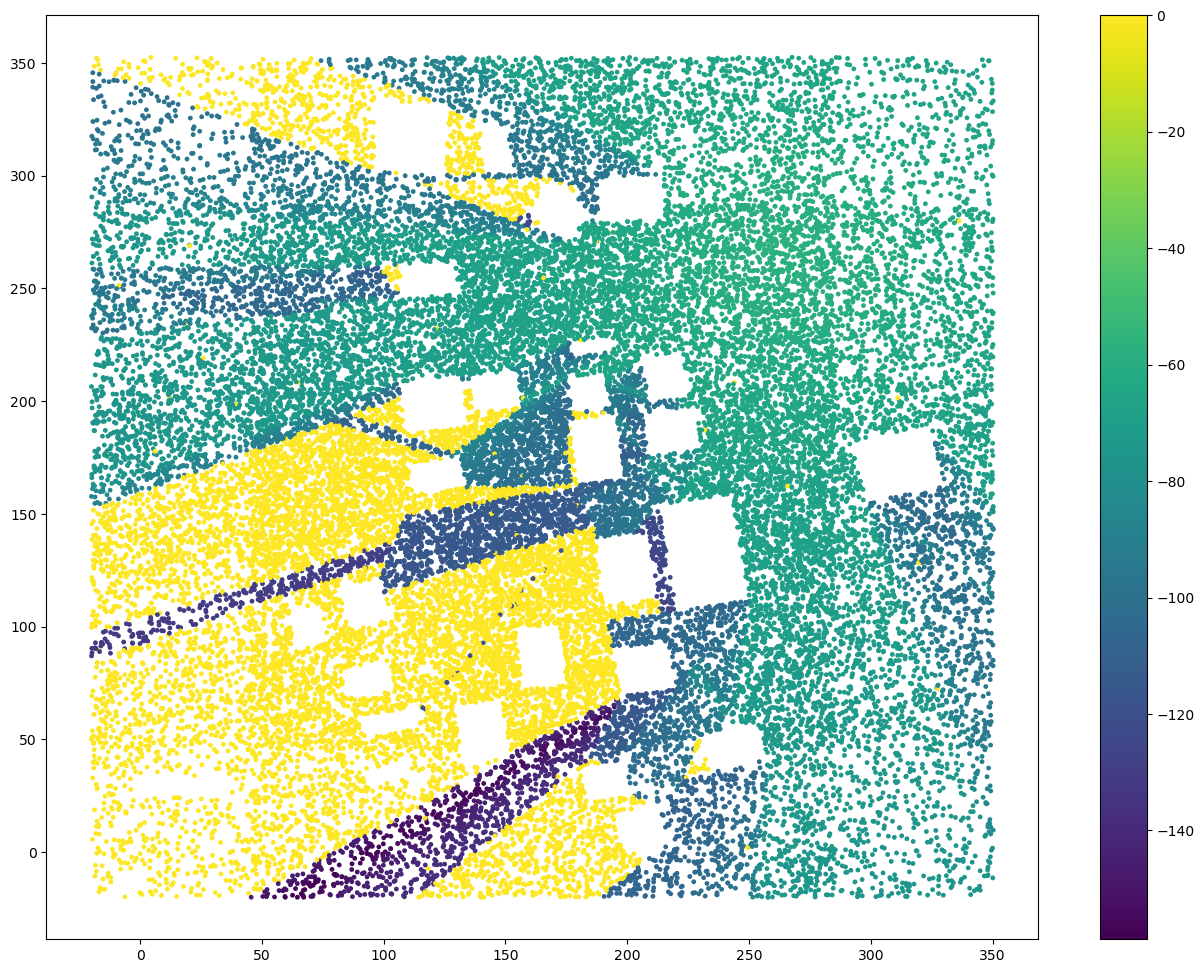

In [7]:
num_users = 90   # total users
num_activate_users = 5
folder = "./RM_baseline/data/train/"
userlist = list(range(1, 91, 10))
# userlist = list(range(1, 11))
datalist = []

for i in userlist:
    clientId = i
    datalist.append(np.reshape(np.load(folder+f'user_{clientId:02d}.npy'),(-1,6)))

data = np.vstack(datalist)
plt.figure(figsize=(16, 12))
plt.scatter(data[:, 0], data[:, 1], s=6, c=data[:,5])
plt.colorbar()

In [3]:
from model import DoraNet
import torch

b = 10
doraNet = DoraNet()
doraNet.load_state_dict(torch.load('./model.pth'))

pos=torch.zeros((b,2))
pathloss=torch.zeros(b,4)

p_pathloss = doraNet(pos)
print(torch.mean(torch.abs(p_pathloss-pathloss)))

tensor(165.2562, grad_fn=<MeanBackward0>)
